# Sarcopenia Classification

### Imports

In [2]:
"""Module for Sarcopenia Classification Tests."""

from io import BytesIO
import base64

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dataframe_image as dfi
from IPython.display import display, HTML

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

import functions_classification as fn

# Load Datasets

In [3]:
# Datos modificados
datos_modificados = pd.read_csv("../data/datos_modificados.csv")

# Datos modificados para sarcopenia
X_sarco_datos = pd.read_csv('../data/sarco/X_sarco_datos_mod.csv', index_col=0)
X_sarco_norm = pd.read_csv('../data/sarco/X_sarco_norm_mod.csv', index_col=0)

# Selected data
X_cor = pd.read_csv('../data/sarco/X_cor_mod.csv', index_col=0)
X_cor_ols = pd.read_csv('../data/sarco/X_cor_ols_mod.csv', index_col=0)
X_forest = pd.read_csv('../data/sarco/X_forest_mod.csv', index_col=0)
X_svm = pd.read_csv('../data/sarco/X_svm_mod.csv', index_col=0)

# Pca data
X_pca_95 = pd.read_csv('../data/sarco/X_pca_95_mod.csv')

# Features with ranking
feature_ranking = pd.read_csv('../data/sarco/feature_ranking_mod.csv')
feature_ranking.rename({'Unnamed: 0': 'feat'}, inplace=True, axis=1)

# Subsets using different amount of features from the aggregated selected features
X_selected_4 = X_sarco_datos[feature_ranking['feat'][0:4]]
X_selected_8 = X_sarco_datos[feature_ranking['feat'][0:8]]
X_selected_all = X_sarco_datos[feature_ranking['feat']]

In [4]:
# Dependent Variable
Y_sarc = datos_modificados['sarcewgsop']

# Class distribution
Y_sarc.value_counts()

sarcewgsop
1    587
0    513
2    153
Name: count, dtype: int64

In [ ]:
# Sort index names alphabetically
X_selected_all.sort_index(axis=1, inplace=True)
X_sarco_datos.sort_index(axis=1, inplace=True)

In [5]:
# Dictionariy of datasets
datasets = {
    'X_sarco_datos': X_sarco_datos,
    'X_cor': X_cor,
    'X_cor_ols': X_cor_ols,
    'X_forest': X_forest,
    'X_pca_95': X_pca_95,
    'X_sarco_norm': X_sarco_norm,
    'X_svm': X_svm,
    'X_selected_4': X_selected_4,
    'X_selected_8': X_selected_8,
    'X_selected_all': X_selected_all
}

datasets_hpt = {
    'X_cor': X_cor,
    'X_cor_ols': X_cor_ols,
    'X_forest': X_forest,
    'X_svm': X_svm,
    'X_selected_4': X_selected_4,
    'X_selected_8': X_selected_8,
    'X_selected_all': X_selected_all,
    'X_sarco_datos': X_sarco_datos,
    'X_sarco_norm': X_sarco_norm
}

In [7]:
# Global variables
METRIC = 'roc_auc'
METRIC_NAME = 'ROC AUC'
RESULTS_MEAN_METRIC = 'mean_test_roc_auc'

# Classification

In [8]:
np.random.seed(42)

# Create pipeline
mlp_pipe = Pipeline(steps=[("scaler", StandardScaler()),
                           ("mlp", MLPClassifier(max_iter=5000, random_state=42))])

svm_pipe = Pipeline(steps=[("scaler", StandardScaler()),
                           ("svm", svm.SVC(kernel='linear', random_state=42, probability=True))])

dict_classifiers_all = {
    "KNN": KNeighborsClassifier(),
    "GradBst": GradientBoostingClassifier(random_state=42),
    "DT": DecisionTreeClassifier(random_state=42),
    "NB": GaussianNB(),
    "SGD": CalibratedClassifierCV(SGDClassifier(random_state=42, loss='log_loss'), cv=5),
    "RndmFor": RandomForestClassifier(random_state=42),
    "MLP": mlp_pipe,
    "SVM": svm_pipe,
}


## Test using all features:
Including those used in calculation of Sarcopenia, to see if performance is greatly improved. We found a paper that trained a model on variables that are used in calculation of sarcopenia, hence this test.

In [ ]:
# List of dependent variables
columns_to_drop = ["sarcewgsop", "sarcopenia_handgrip", "sarcopenia_v"]

# Create subset by removing those variables
data = datos_modificados.drop(columns_to_drop, axis=1)

# List of columns to keep
columns_to_keep = ['id_3', 'sexo', 'edad', 'hand_izq', 'hand_drch',
                   'altura', 'peso', 'imc', 'grasa', 'músculo', 'agil_m_s',
                   'andar_agil4m', 'sentadilla', 'relative_power', 'pnts_eq']

# Create subset by futher filtering dataset
data_w_related_variables = datos_modificados[columns_to_keep]

In [10]:
# Dictionary of datasets to use
dataset = {'data': data_w_related_variables}

# Get classification results
results_df, best_model, best_score = fn.baseline_test(dataset,
                                                      Y_sarc,
                                                      dict_classifiers_all)

# Export Results
results_df.to_csv('../results/sarco/baseline_all_feat.csv')

# Print Best model(s) and score
fn.get_models_and_scores("limpios", best_model, best_score)

  0%|          | 0/1 [00:00<?, ?it/s]

------ DONE ------
Best model(s) for datos limpios:
GradBst:data
Highest accuracy: 0.96488



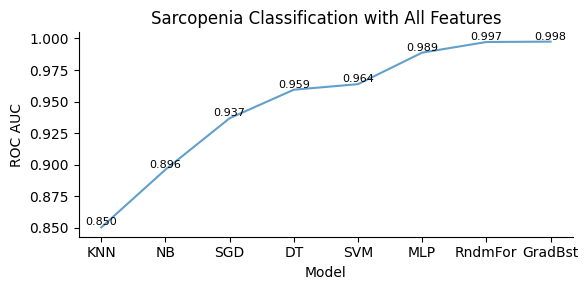

In [11]:
# Load data
results_df = pd.read_csv('../results/sarco/baseline_all_feat.csv')
results_df = results_df.drop(['dataset'], axis=1)
results_df = results_df.set_index('metric')
results_df = np.round(results_df, decimals=4)
results_df.sort_values(METRIC, axis=1, inplace=True)

# Plot results
fig, ax = plt.subplots(figsize=(6, 3))

selected_metric = results_df.loc[METRIC]
selected_metric.plot.line(ax=ax, rot=0, alpha=.7, legend=False)

# Add labels to each point
for i, value in enumerate(selected_metric):
    ax.text(i, value, f"{value:.3f}", fontsize=8, ha='center', va='bottom')

ax.set_title('Sarcopenia Classification with All Features')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')

#ax.bar_label(ax.containers[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
plt.savefig('../plots/sarco/results_all_feat.png')

# 1. Baseline Test

Compare Model and Dataset Combinations

### Train models

In [12]:
# Get baseline classification results
results_df, best_model, best_score = fn.baseline_test(datasets,
                                                      Y_sarc,
                                                      dict_classifiers_all)

# Export Baseline Results
results_df.to_csv('../results/sarco/baseline_kfold.csv')

# Best baseline model(s) and results
fn.get_models_and_scores("limpios", best_model, best_score)

  0%|          | 0/10 [00:00<?, ?it/s]

------ DONE ------
Best model(s) for datos limpios:
SVM:X_cor_ols
Highest accuracy: 0.61776



In [13]:
# Load data
# results_baseline_df = pd.read_csv('../results/sarco/baseline_kfold.csv').ffill().set_index(['dataset', 'metric'])

# Select only certain metrics
# results_baseline_df.loc(axis=0)[:, ['accuracy', 'precision', 'recall']].sort_index()

### Load results and compare

In [14]:
# Load results
results_baseline_df = pd.read_csv('../results/sarco/baseline_kfold.csv').ffill().set_index(['dataset', 'metric'])

# Print max and average scores for each model
for col in results_baseline_df.columns:
    average = round(results_baseline_df[col].mean(), 5)

    print(f"{col}:")
    print(f"    ----- Highest score (all metrics): {results_baseline_df[col].max()}")
    print(f"    ----- Average score (all metrics): {average}")

SVM:
    ----- Highest score (all metrics): 0.75847
    ----- Average score (all metrics): 0.53012
NB:
    ----- Highest score (all metrics): 0.75102
    ----- Average score (all metrics): 0.58154
KNN:
    ----- Highest score (all metrics): 0.68797
    ----- Average score (all metrics): 0.50177
RndmFor:
    ----- Highest score (all metrics): 0.74573
    ----- Average score (all metrics): 0.56689
MLP:
    ----- Highest score (all metrics): 0.75817
    ----- Average score (all metrics): 0.57204
GradBst:
    ----- Highest score (all metrics): 0.7387
    ----- Average score (all metrics): 0.56336
DT:
    ----- Highest score (all metrics): 0.59946
    ----- Average score (all metrics): 0.48465
SGD:
    ----- Highest score (all metrics): 0.7564
    ----- Average score (all metrics): 0.5457


### Load baseline results and concat into one dataframe with select metrics

In [65]:
# Load results and filter by selected metrics, then save filtered data to csv
# Load results
metrics = ['roc_auc', 'f1', 'accuracy']
results_baseline_df = pd.read_csv('../results/sarco/baseline_kfold.csv').ffill().set_index(['dataset', 'metric'])
results_baseline_df = results_baseline_df.loc(axis=0)[:, metrics].sort_index()

cols = ['SVM', 'NB', 'KNN', 'RndmFor', 'MLP', 'GradBst', 'DT', 'SGD' ]
results_baseline_df = results_baseline_df[cols]
results_baseline_df = results_baseline_df.round(4)

results_baseline_df.to_csv('../results/sarco/baseline_kfold_filtered.csv')
results_baseline_df

SVM      NB     KNN  RndmFor     MLP  GradBst  \
dataset        metric                                                       
X_cor          accuracy  0.5962  0.5923  0.5260   0.5755  0.5802   0.5770   
               f1        0.4217  0.5166  0.4395   0.5002  0.4399   0.4842   
               roc_auc   0.7369  0.7446  0.6512   0.7076  0.7418   0.7140   
X_cor_ols      accuracy  0.6178  0.5372  0.5220   0.5683  0.6058   0.5810   
               f1        0.4370  0.4998  0.4319   0.4864  0.4807   0.5120   
               roc_auc   0.7552  0.7449  0.6456   0.7359  0.7550   0.7387   
X_forest       accuracy  0.6010  0.5930  0.5204   0.5962  0.5890   0.5683   
               f1        0.4248  0.5404  0.4453   0.5237  0.4908   0.5140   
               roc_auc   0.7476  0.7510  0.6521   0.7369  0.7495   0.7223   
X_pca_95       accuracy  0.5962  0.5762  0.4310   0.5482  0.5778   0.5244   
               f1        0.4196  0.4631  0.2636   0.4581  0.4466   0.4536   
               roc_auc   0.7392  0.7209  0.5238   0.7056  0.7303   0.7158   
X_sarco_datos  accuracy  0.6122  0.5316  0.5435   0.5834  0.5986   0.5730   
               f1        0.4327  0.5041  0.4610   0.5077  0.4890   0.5121   
               roc_auc   0.7508  0.7467  0.6664   0.7376  0.7528   0.7382   
X_sarco_norm   accuracy  0.6122  0.5555  0.5619   0.5978  0.5946   0.5874   
               f1        0.4335  0.5256  0.4855   0.5000  0.4780   0.4898   
               roc_auc   0.7525  0.7468  0.6880   0.7457  0.7508   0.7296   
X_selected_4   accuracy  0.5898  0.5778  0.4908   0.5603  0.5810   0.5611   
               f1        0.4164  0.5303  0.4167   0.4822  0.5012   0.4758   
               roc_auc   0.7038  0.7439  0.6341   0.7050  0.7402   0.7152   
X_selected_8   accuracy  0.6138  0.5452  0.5252   0.5818  0.6042   0.5898   
               f1        0.4336  0.5198  0.4409   0.5024  0.4907   0.5090   
               roc_auc   0.7585  0.7477  0.6514   0.7444  0.7546   0.7355   
X_selected_all accuracy  0.6122  0.5316  0.5435   0.5834  0.5986   0.5730   
               f1        0.4327  0.5041  0.4610   0.5077  0.4890   0.5121   
               roc_auc   0.7508  0.7467  0.6664   0.7376  0.7528   0.7382   
X_svm          accuracy  0.6138  0.5428  0.5404   0.5779  0.5962   0.5779   
               f1        0.4334  0.5162  0.4657   0.4883  0.4976   0.4823   
               roc_auc   0.7575  0.7468  0.6606   0.7378  0.7582   0.7332   

                             DT     SGD  
dataset        metric                    
X_cor          accuracy  0.4877  0.5818  
               f1        0.4367  0.4118  
               roc_auc   0.5807  0.7255  
X_cor_ols      accuracy  0.5068  0.5946  
               f1        0.4489  0.4289  
               roc_auc   0.5883  0.7389  
X_forest       accuracy  0.4925  0.5954  
               f1        0.4323  0.4321  
               roc_auc   0.5775  0.7392  
X_pca_95       accuracy  0.4740  0.4940  
               f1        0.4194  0.3640  
               roc_auc   0.5624  0.7347  
X_sarco_datos  accuracy  0.5036  0.6058  
               f1        0.4501  0.4429  
               roc_auc   0.5908  0.7462  
X_sarco_norm   accuracy  0.5005  0.6010  
               f1        0.4413  0.4455  
               roc_auc   0.5843  0.7564  
X_selected_4   accuracy  0.5108  0.5890  
               f1        0.4491  0.4394  
               roc_auc   0.5885  0.7240  
X_selected_8   accuracy  0.5228  0.6042  
               f1        0.4642  0.4405  
               roc_auc   0.5995  0.7405  
X_selected_all accuracy  0.5036  0.6058  
               f1        0.4501  0.4429  
               roc_auc   0.5908  0.7462  
X_svm          accuracy  0.4988  0.6058  
               f1        0.4388  0.4456  
               roc_auc   0.5821  0.7459

### Create table for baseline AUC results

In [ ]:
# Load results
results_baseline_df = pd.read_csv('../results/sarco/baseline_kfold.csv').ffill().set_index(['dataset', 'metric'])
results_baseline_df = results_baseline_df.loc(axis=0)[:, METRIC].copy() # Select only roc_auc

# Rename columns
column_names = {'RndmFor':'RF', 'MLP':'MLP', 'KNN':'KNN',
                'GradBst':'GB', 'SVM': 'SVM'}
results_baseline_df.rename(columns=column_names, inplace=True)

# Change index names
index_names = ['Full', 'Spearman Select', 'OLS Select',
               'RF Select', 'PCA', 'Full Normalized',
               'SVM Select', 'Aggregated First 4',
               'Aggregated First 8', 'Aggregated All']
results_baseline_df['Dataset'] = index_names
results_baseline_df.set_index('Dataset', inplace=True)

# Change index order
index_order = ['Spearman Select', 'OLS Select', 'RF Select',
               'SVM Select', 'Aggregated First 4', 'Aggregated First 8',
               'Aggregated All', 'Full',  'Full Normalized']

results_baseline_df = results_baseline_df.reindex(index = index_order)

### Stylize table

,SVM,NB,KNN,RF,MLP,GB,DT,SGD
Dataset,,,,,,,,
Spearman Select,0.7369,0.7446,0.6512,0.7076,0.7418,0.7140,0.5807,0.7255
OLS Select,0.7552,0.7449,0.6456,0.7359,0.7550,0.7387,0.5883,0.7389
RF Select,0.7476,0.7510,0.6521,0.7369,0.7495,0.7223,0.5775,0.7391
SVM Select,0.7575,0.7468,0.6606,0.7378,0.7582,0.7332,0.5821,0.7459
Aggregated First 4,0.7038,0.7439,0.6341,0.7050,0.7402,0.7152,0.5885,0.7240
Aggregated First 8,0.7585,0.7477,0.6514,0.7444,0.7546,0.7355,0.5995,0.7405
Aggregated All,0.7508,0.7467,0.6664,0.7376,0.7528,0.7382,0.5908,0.7462
Full,0.7508,0.7467,0.6664,0.7376,0.7528,0.7382,0.5908,0.7462
Full Normalized,0.7525,0.7468,0.6880,0.7457,0.7508,0.7296,0.5843,0.7564

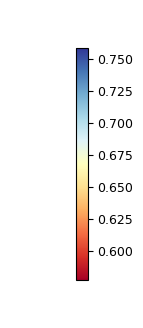

In [62]:
# Create stylized table
results_df_colored = results_baseline_df.style.format("{:.4f}").background_gradient(
    axis=None, cmap="RdYlBu").set_table_styles(
    [
        {'selector': 'th', 'props': [('padding', '10px')]},  # Header padding
        {'selector': 'td', 'props': [('padding', '10px')]},   # Cell padding
        {'selector': 'th.row_heading', 'props': [('padding-left', '20px'), ('text-align', 'left')]},  # Row labels    
        ]
)

fig, ax = plt.subplots(figsize=(1,4))

# Create a colorbar values using min and max of dataset
norm = plt.Normalize(results_baseline_df.min().min(), results_baseline_df.max().max())
sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=norm)
sm.set_array([])

# Remove the axis
ax.axis("off")

# Create the colorbar
fig.colorbar(sm, ax=ax)

# Save the colorbar to a PNG image and convert to base64
buf = BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
buf.seek(0)
colorbar_base64 = base64.b64encode(buf.read()).decode('utf-8')
colorbar_html = f'<img src="data:image/png;base64,{colorbar_base64}" style="margin-left: 20px;"/>'

# Combine the styled DataFrame and the colorbar
html = results_df_colored.to_html()
combined_html = f'<div style="display: flex; align-items: center;">{html}{colorbar_html}</div>'

# Display the combined output
display(HTML(combined_html))

# Close the figure to prevent it from displaying below the table
plt.close(fig)

dfi.export(results_df_colored,
           "../plots/sarco/results_df_1baseline.png",
           table_conversion='matplotlib',
           dpi=300
          )

In [ ]:
# Print highest and average of selected metric per model

print(f"Printing highest and average of {METRIC_NAME} per model:")
for col in results_baseline_df.columns:
    average = round(results_baseline_df[col].mean(), 5)

    print(f"{col}:")
    print(f"    ----- Highest {METRIC_NAME}: {results_baseline_df[col].max()}")
    print(f"    ----- Average {METRIC_NAME}: {average}")

Printing highest and average of ROC AUC per model:
SVM:
    ----- Highest ROC AUC: 0.75847
    ----- Average ROC AUC: 0.74595
NB:
    ----- Highest ROC AUC: 0.75102
    ----- Average ROC AUC: 0.74657
KNN:
    ----- Highest ROC AUC: 0.68797
    ----- Average ROC AUC: 0.6573
RF:
    ----- Highest ROC AUC: 0.74573
    ----- Average ROC AUC: 0.73207
MLP:
    ----- Highest ROC AUC: 0.75817
    ----- Average ROC AUC: 0.75062
GB:
    ----- Highest ROC AUC: 0.7387
    ----- Average ROC AUC: 0.72943
DT:
    ----- Highest ROC AUC: 0.59946
    ----- Average ROC AUC: 0.58694
SGD:
    ----- Highest ROC AUC: 0.7564
    ----- Average ROC AUC: 0.74031


Best performers in sarcopenia are NB, MLP, RF, and SVM.

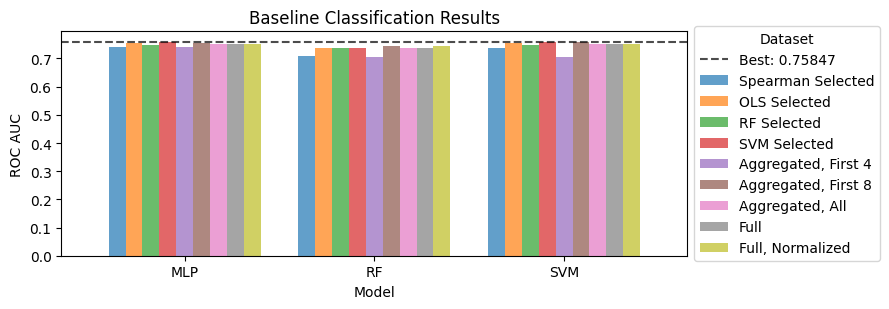

In [18]:
# Select only best models to visualize
results_baseline_df = results_baseline_df.reindex(columns=['MLP','RF','SVM'])
max_value = results_baseline_df.max().max()

# Plot results
fig, ax = plt.subplots(figsize=(9, 3.2))

results_baseline_df.transpose().plot.bar(ax=ax, rot=0, width=.8, alpha=.7)
ax.set_title('Baseline Classification Results')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')
plt.axhline(y=max_value, color='black', linestyle='--', alpha=0.7, label=f"Best: {max_value:.5f}")
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Dataset')

fig.tight_layout()
plt.savefig('../plots/sarco/results_1baseline.png')

# 2. Hyperparameter Tuning

## SVM - Ajuste de Hiperparámetros

In [19]:
# Dictionary of SVM hyperparameters
svm_params = {
    'svm__C':[1.0, 10.0, 100.0],           # Strength of regularization
    'svm__kernel':['rbf', 'linear', 'poly', 'sigmoid'],
    'svm__degree':[3, 4, 5, 6],            # Degree of poly kernel, ignored by others
    'svm__class_weight':[None,'balanced'],
    'svm__random_state' : [42],            # For reproducibility
    'svm__probability': [True]
}

# Create pipeline to scale data and pipeline
svm_pipe = Pipeline(steps=[("scaler", StandardScaler()), ("svm", svm.SVC())])

In [20]:
# Run gridsearch for SVM
results_svm, best_params_svm, best_model_svm, best_score_svm, cv_results_svm = fn.gridsearch(
    datasets_hpt,
    Y_sarc,
    svm_params,
    svm_pipe,
)

# Save classification results to csv
results_svm.to_csv('../results/sarco/classification_svm_results.csv')

# Print best model(s) and score
print(f"Best model: {best_model_svm}\nBest Score: {best_score_svm}")

  0%|          | 0/9 [00:00<?, ?it/s]

{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 10.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42

In [21]:
# Create df of best hyperparams per dataset
best_params_svm_df = pd.DataFrame(best_params_svm.items(), columns=['dataset', 'parameters'])
best_params_svm_df.set_index('dataset', inplace=True)  # Set dataset as index

# Create df of gridsearch results
cv_results_svm_df = pd.DataFrame.from_dict(cv_results_svm)

# Export as csv´s
best_params_svm_df.to_csv('../results/sarco/best_params_per_dataset_svm.csv')
cv_results_svm_df.to_csv('../results/sarco/cv_results_svm_df.csv')

In [ ]:
# Available columns in results df
pd.DataFrame(cv_results_svm).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svm__C', 'param_svm__class_weight', 'param_svm__degree',
       'param_svm__kernel', 'param_svm__probability',
       'param_svm__random_state', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall', 'split4_test_recall',
       'mean_test_recall', 'std_test_recall', 'rank_test_recall',
       'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc',
       'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc',
 

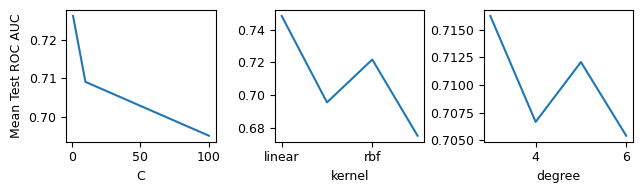

In [71]:
# Plot hyperparameter tuning results
hyperparameters = ['svm__C', 'svm__kernel', 'svm__degree']
param_name = ['C', 'kernel', 'degree']

n_hyperparameters = len(hyperparameters)
results = pd.DataFrame(cv_results_svm)
results[RESULTS_MEAN_METRIC] = results[RESULTS_MEAN_METRIC].round(2)

fig, axs = plt.subplots(1, n_hyperparameters, figsize=(6.5, 2))

for i, hyperparameter in enumerate(hyperparameters):
    ax = axs[i] if n_hyperparameters > 1 else axs
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    results_mean.plot(ax=ax, legend=False)

    ax.set_xlabel(param_name[i])
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")

plt.tight_layout()
plt.savefig('../plots/sarco/results_2svm.png', dpi=300)
plt.show()

## RFC - Ajuste de Hiperparámetros

In [24]:
# Dictionary of RFC hyperparams
rfc_params = {
    'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_features':['sqrt', 'log2', None],
    'random_state':[42],
    'class_weight':['balanced', None],
}

In [25]:
# Run gridsearch for RFC
results_rfc, best_params_rfc, best_model_rfc, best_score_rfc, cv_results_rfc = fn.gridsearch(
    datasets_hpt,
    Y_sarc,
    rfc_params,
    RandomForestClassifier()
)

# Export classification results as csv
results_rfc.to_csv('../results/sarco/classification_rfc_results.csv')

# Print best model(s) and score
print(f"Best model: {best_model_rfc}\nBest Score: {best_score_rfc}")

  0%|          | 0/9 [00:00<?, ?it/s]

{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'log2', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': None, 'n_estimators': 100, 'random_state': 42}
{'class_weight': None, 'max_features': None, 'n_estimators': 100, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
------ DONE ------
Best model: ['RandomForestClassifier():X_selected_8']
Best Score: 0.74628


In [26]:
# Create df of best params per dataset
best_params_rfc_df = pd.DataFrame(best_params_rfc.items(), columns=['dataset', 'parameters'])
best_params_rfc_df.set_index('dataset', inplace=True)  # Set dataset as index

# Create df of gridsearch results
cv_results_rfc_df = pd.DataFrame.from_dict(cv_results_rfc)

# # Export as csv´s
best_params_rfc_df.to_csv('../results/sarco/best_params_per_dataset_rfc.csv')
cv_results_rfc_df.to_csv('../results/sarco/cv_results_rfc_df.csv')

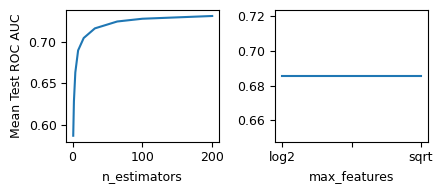

In [75]:
# Plot hyperparameter tuning results for RFC
hyperparameters = ['n_estimators', 'max_features']
n_hyperparameters = len(hyperparameters)

results = pd.DataFrame(cv_results_rfc)
results[RESULTS_MEAN_METRIC] = results[RESULTS_MEAN_METRIC].astype('float64').round(2).copy()

fig, axs = plt.subplots(1, n_hyperparameters, figsize=(4.5, 2))

for i, hyperparameter in enumerate(hyperparameters):
    ax = axs[i] if n_hyperparameters > 1 else axs
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    results_mean.plot(ax=ax, legend=False)

    ax.set_xlabel(hyperparameter)
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")

plt.tight_layout()
plt.savefig('../plots/sarco/results_2rf.png', dpi=300)
plt.show()

## MLP - Ajuste de Hiperparámetros

In [28]:
# Dictionary of MLP params
layer_sizes = [(10,), (100,), (200,), (10,10), (10,100), (100,100), (10,10,10), (100,100,100)]
mlp_params = {
    'mlp__hidden_layer_sizes':layer_sizes,
    'mlp__activation':['logistic', 'tanh', 'relu'],
    'mlp__learning_rate':['constant', 'adaptive'],
    'mlp__max_iter':[5000],
    'mlp__random_state':[42],
}

# Create pipeline to scale data and pipeline
mlp_pipe = Pipeline(steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier())])

In [29]:
# Run MLP gridsearch
results_mlp, best_params_mlp, best_model_mlp, best_score_mlp, cv_results_mlp = fn.gridsearch(
    datasets_hpt,
    Y_sarc,
    mlp_params,
    mlp_pipe
)

# Export model results to csv
results_mlp.to_csv('../results/sarco/classification_mlp_results.csv')

# Print best model(s) and score
print(f"Best model: {best_model_mlp}\nBest Score: {best_score_mlp}")

  0%|          | 0/9 [00:00<?, ?it/s]

{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (200,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (200,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (200,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (10,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (200,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__max_iter

In [30]:
# Create df of best params per dataset
best_params_mlp_df = pd.DataFrame(best_params_mlp.items(), columns=['dataset', 'parameters'])
best_params_mlp_df.set_index('dataset', inplace=True)  # Set dataset as index

# Create df of gridsearch results
cv_results_mlp_df = pd.DataFrame.from_dict(cv_results_mlp)

# Export to csv's
best_params_mlp_df.to_csv('../results/sarco/best_params_per_dataset_mlp.csv')
cv_results_mlp_df.to_csv('../results/sarco/cv_results_mlp_df.csv')

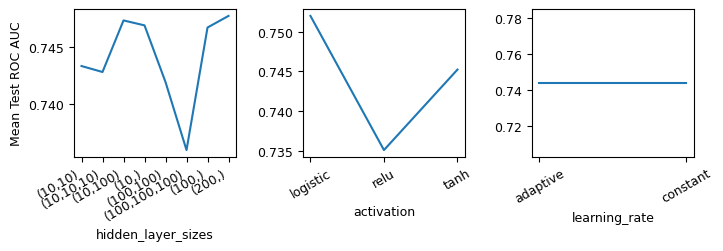

In [83]:
# Plot hyperparameter tuning results
cv_results_mlp = pd.read_csv('../results/sarco/cv_results_mlp_df.csv')

plt.rcParams.update({'font.size': 9})

hyperparameters = ['mlp__hidden_layer_sizes', 'mlp__activation', 'mlp__learning_rate']
param_name = ['hidden_layer_sizes', 'activation', 'learning_rate']

n_hyperparameters = len(hyperparameters)
results = pd.DataFrame(cv_results_mlp)

fig, axs = plt.subplots(1, n_hyperparameters, figsize=(7.3, 2.6))

for i, hyperparameter in enumerate(hyperparameters):
    ax = axs[i] if n_hyperparameters > 1 else axs
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    results_mean.plot(ax=ax, legend=False, rot=30)

    ax.set_xlabel(param_name[i])
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")

plt.setp(axs[0].get_xticklabels(), ha="right")

labels = ['(10,10)','(10,10,10)','(10,100)','(10,)','(100,100)','(100,100,100)','(100,)','(200,)']
axs[0].set_xticks([0,1,2,3,4,5,6,7])
axs[0].set_xticklabels(labels)

axs[2].set_xticks([0,1])
axs[2].set_xticklabels(['adaptive','constant'])

plt.tight_layout()
plt.savefig('../plots/sarco/results_2mlp.png', dpi=300)
plt.show()

## Compare Hyperparameter Tuning Results

### Load and concat results

In [93]:
# Load hyperparam classification results
results_svm = pd.read_csv('../results/sarco/classification_svm_results.csv', index_col=0)
results_svm.rename({METRIC:'svm'}, inplace=True, axis=1)
results_svm = pd.DataFrame(results_svm['svm'])

results_rfc = pd.read_csv('../results/sarco/classification_rfc_results.csv', index_col=0)
results_rfc.rename({METRIC:'rfc'}, inplace=True, axis=1)
results_rfc = pd.DataFrame(results_rfc['rfc'])

results_mlp = pd.read_csv('../results/sarco/classification_mlp_results.csv', index_col=0)
results_mlp.rename({METRIC:'mlp'}, inplace=True, axis=1)
results_mlp = pd.DataFrame(results_mlp['mlp'])

# Concat into one df
gridsearch_results = pd.concat([results_mlp, results_rfc, results_svm ], axis=1)

### Make column and index names more presentable

In [ ]:
# Rename columns
column_names = {'mlp':'MLP',
                'rfc':'RF',
                'svm': 'SVM'
               }
gridsearch_results.rename(columns=column_names, inplace=True)

# Rename index
index_names = ['Pearson Select', 'OLS Select', 'Random Forest Select',
               'SVM Select', 'Aggregated First 4', 'Aggregated First 8',
               'Aggregated All',  'Full', 'Full Normalized'
              ]
gridsearch_results['Dataset'] = index_names
gridsearch_results.set_index('Dataset', inplace=True)

### Plot Classification results

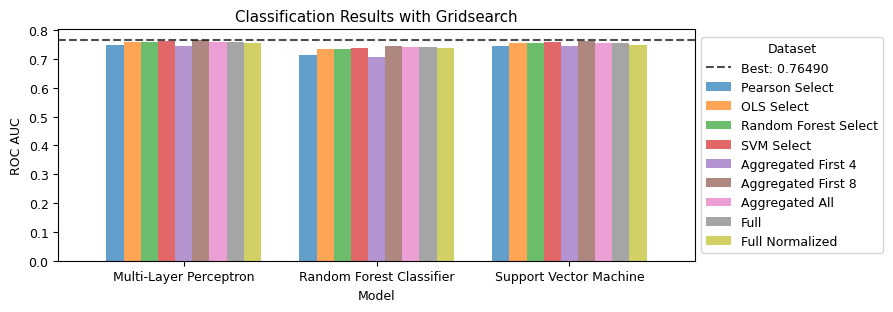

In [95]:
max_value = gridsearch_results.max().max()

# Plot gridsearch results
fig, ax = plt.subplots(figsize=(9,3.2))
gridsearch_results.transpose().plot.bar(ax=ax, rot=0, width=.8, alpha=.7)
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_title('Classification Results with Gridsearch')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')
ax.set_xticklabels(['Multi-Layer Perceptron', 'Random Forest Classifier', 'Support Vector Machine'])
plt.axhline(y=max_value, color='black', linestyle='--', alpha=0.7, label=f"Best: {max_value:.5f}")
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Dataset')

fig.tight_layout()
plt.savefig('../plots/sarco/results_2gridsearch.png')

,MLP,RF,SVM
Dataset,,,
Pearson Select,0.7483,0.7126,0.7461
OLS Select,0.7595,0.7358,0.7574
Random Forest Select,0.7587,0.7351,0.7540
SVM Select,0.7640,0.7392,0.7604
Aggregated First 4,0.7464,0.7062,0.7456
Aggregated First 8,0.7649,0.7463,0.7615
Aggregated All,0.7603,0.7404,0.7548
Full,0.7603,0.7404,0.7548
Full Normalized,0.7546,0.7372,0.7491

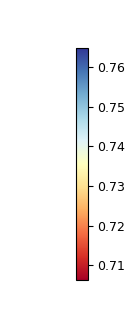

In [ ]:
# Rename columns
column_names = {'MLP':'MLP', 'RndmFor':'RF', 'SVM': 'SVM'}
gridsearch_results.rename(columns=column_names, inplace=True)

# Round dataframe to 4 decimals
gridsearch_results = gridsearch_results.round(4)

# Create stylized table
gridsearch_results_colored = gridsearch_results.style.format("{:.4f}").background_gradient(
    axis=None,
    cmap="RdYlBu",
)

fig, ax = plt.subplots(figsize=(1,4))
norm = plt.Normalize(gridsearch_results.min().min(), gridsearch_results.max().max())
sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=norm)
sm.set_array([])

# Remove the axis
ax.axis("off")

# Create the colorbar
fig.colorbar(sm, ax=ax)

# Save the colorbar to a PNG image and convert to base64
buf = BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
buf.seek(0)
colorbar_base64 = base64.b64encode(buf.read()).decode('utf-8')
colorbar_html = f'<img src="data:image/png;base64,{colorbar_base64}" style="margin-left: 20px;"/>'

# Combine the styled DataFrame and the colorbar
html = gridsearch_results_colored.to_html()
combined_html = f'<div style="display: flex; align-items: center;">{html}{colorbar_html}</div>'

# Display the combined output
display(HTML(combined_html))

# Close the figure to prevent it from displaying below the table
plt.close(fig)

dfi.export(gridsearch_results_colored,
           "../plots/sarco/results_df_2gridsearch.png",
           table_conversion='matplotlib',
           dpi=300
          )

# Load final results to join dataframe

In [98]:
metrics = ['roc_auc', 'f1', 'accuracy', 'dataset']

results_svm = pd.read_csv('../results/sarco/classification_svm_results.csv')
results_svm = results_svm[metrics]
# Melt the DataFrame to prepare for MultiIndex creation
results_svm = results_svm.melt(id_vars=['dataset'], var_name='metrics', value_name='svm')
results_svm = results_svm.set_index(['dataset', 'metrics'])  # Set the MultiIndex
results_svm = results_svm.sort_index()

results_rfc = pd.read_csv('../results/sarco/classification_rfc_results.csv')
results_rfc = results_rfc[metrics]
# Melt the DataFrame to prepare for MultiIndex creation
results_rfc = results_rfc.melt(id_vars=['dataset'], var_name='metrics', value_name='rfc')
results_rfc = results_rfc.set_index(['dataset', 'metrics'])  # Set the MultiIndex
results_rfc = results_rfc.sort_index()

results_mlp = pd.read_csv('../results/sarco/classification_mlp_results.csv')
results_mlp = results_mlp[metrics]
# Melt the DataFrame to prepare for MultiIndex creation
results_mlp = results_mlp.melt(id_vars=['dataset'], var_name='metrics', value_name='mlp')
results_mlp = results_mlp.set_index(['dataset', 'metrics'])  # Set the MultiIndex
results_mlp = results_mlp.sort_index()

results = pd.concat([results_svm, results_rfc, results_mlp], axis=1)
results = results.round(4)
results.to_csv('../results/sarco/classification_results_all.csv')
results

svm     rfc     mlp
dataset        metrics                         
X_cor          accuracy  0.7461  0.7126  0.7483
               f1        0.5011  0.4896  0.5084
               roc_auc   0.7461  0.7126  0.7483
X_cor_ols      accuracy  0.7574  0.7358  0.7595
               f1        0.5153  0.4906  0.5045
               roc_auc   0.7574  0.7358  0.7595
X_forest       accuracy  0.7540  0.7351  0.7587
               f1        0.5042  0.5066  0.4851
               roc_auc   0.7540  0.7351  0.7587
X_sarco_datos  accuracy  0.7548  0.7404  0.7603
               f1        0.4986  0.5155  0.4723
               roc_auc   0.7548  0.7404  0.7603
X_sarco_norm   accuracy  0.7491  0.7372  0.7546
               f1        0.4283  0.4875  0.4290
               roc_auc   0.7491  0.7372  0.7546
X_selected_4   accuracy  0.7456  0.7062  0.7464
               f1        0.5003  0.4989  0.4554
               roc_auc   0.7456  0.7062  0.7464
X_selected_8   accuracy  0.7615  0.7463  0.7649
               f1        0.5045  0.5150  0.4765
               roc_auc   0.7615  0.7463  0.7649
X_selected_all accuracy  0.7548  0.7404  0.7603
               f1        0.4986  0.5155  0.4723
               roc_auc   0.7548  0.7404  0.7603
X_svm          accuracy  0.7604  0.7392  0.7640
               f1        0.5058  0.4905  0.4326
               roc_auc   0.7604  0.7392  0.7640